In [ ]:
MODEL_NAME = "test_plot"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from multiprocessing.dummy import freeze_support
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


from dotenv import load_dotenv
load_dotenv()
os.environ['WANDB_NOTEBOOK_NAME'] = 'n-beats.ipynb'
os.environ['WANDB_API_KEY'] = os.getenv('WANDB_API_KEY')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from darts import TimeSeries
from darts.models import NBEATSModel, NaiveDrift
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score, rmse, mse

from darts import TimeSeries

from darts.datasets import EnergyDataset

import helper
import glob
import wandb

from pytorch_lightning.loggers import WandbLogger

from tqdm.contrib.concurrent import process_map
import tqdm


AVAILABLE_GPUS = torch.cuda.device_count()
AVAILABLE_CPUS = os.cpu_count()

print(f"Available GPUs: {AVAILABLE_GPUS}")
print(f"Available CPUs: {AVAILABLE_CPUS}")

# wandb.init(project="Digital-Energy", name=MODEL_NAME)


2022-05-20 17:15:12 apex.transformer.tensor_parallel WARNING: `fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.
2022-05-20 17:15:13 root WARNING: Bagua cannot detect bundled NCCL library, Bagua will try to use system NCCL instead. If you encounter any error, please run `import bagua_core; bagua_core.install_deps()` or the `bagua_install_deps.py` script to install bundled libraries.


Available GPUs: 2
Available CPUs: 32


# Data

Taking the first 300 households from the London Dataset and converting them to a Darts TimeSeries.

In [ ]:
# my_time_series_dataset = []
# for x in tqdm.tqdm(sorted(glob.glob("../../../Data/london_clean/*.csv"))[:1000]):
#     df = pd.read_csv(f'{x}')
#     df["DateTime"] = pd.to_datetime(df['DateTime'])
#     # df = df.groupby(pd.Grouper(key='DateTime', freq='1D')).max("KWHhh").round(3).reset_index()
#     series = TimeSeries.from_dataframe(df, time_col='DateTime', value_cols='KWHhh').astype(np.float32)
#     #plot series and save
#     series.plot()
#     plt.savefig(f'../../../Plots/testing/{x.split("/")[-1]}.png')
#     plt.close()


#     my_time_series_dataset.append(series)

In [ ]:
def reader(x):
    return TimeSeries.from_csv(x, time_col='DateTime', value_cols='KWHhh',
                            fill_missing_dates=True, fillna_value=True, freq="30min").astype(np.float32)


def splitter():
    file_list = sorted(glob.glob("../../../Data/london_clean/*.csv"))[:1000]
    if file_list == []:
        raise Exception("No files found")
    return process_map(reader, file_list, chunksize=5)

if __name__ == "__main__":
    freeze_support()
    my_time_series_dataset = splitter()

In [ ]:
## Delete too small data

def reader(x):
    df = pd.read_csv(f'{x}')
    if len(df) < 2000:
        print(f"{x} is too short")
        os.remove(x)

def splitter():
    file_list = sorted(glob.glob("../../../Data/london_clean/*.csv"))[:5000]
    if file_list == []:
        raise Exception("No files found")
    return process_map(reader, file_list, chunksize=5)

if __name__ == "__main__":
    freeze_support()
    my_time_series_dataset = splitter()

In [ ]:
import random
my_time_series_dataset[random.randint(0, len(my_time_series_dataset))].plot()

In [ ]:
## sets
training_sets = []
validation_sets = []
for x in my_time_series_dataset:
    train, val = x.split_after(0.75)
    training_sets.append(train)
    validation_sets.append(val)

In [ ]:
# for i in my_time_series_dataset:
#     helper.find_gaps(i.pd_dataframe(), delta=60*24)

# Model

We create a N-Beats model that utilizes the GPU, Weights, Biases logger and early stopping callback.

## Early stopping

An early stopping callback is used to stop the training if the validation loss does not improve after a certain number of epochs.


In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,
    patience=15,
    verbose=True,
    mode="min"
    )

In [ ]:
encoders = {
    # "datetime_attribute": {"future": ["DateTime"], "past": ["DateTime"]},
    "position": {"past": ["absolute"]},
    "transformer": Scaler(),
}

In [ ]:
wandb_logger = WandbLogger(project="Digital-Energy", log_model=True)


# input chunk = The length of the input sequence fed to the model
# output chunk = The length of the output sequence predicted by the model

model_nbeats = NBEATSModel(
    input_chunk_length=3,
    output_chunk_length=1,
    generic_architecture=False,
    #num_stacks=10,
    num_blocks=3,
    num_layers=5,
    layer_widths=512,
    n_epochs=25,
    nr_epochs_val_period=1,
    batch_size=256,
    work_dir="../../../Models",
    save_checkpoints=False,
    # model_name=MODEL_NAME,
    pl_trainer_kwargs={
    "enable_progress_bar": True,
    "enable_model_summary": True,
    "accelerator": "gpu",
    "devices": 1,
    "logger": wandb_logger,
    "callbacks": [early_stop_callback],
    },
    # loss_fn=torch.nn.CrossEntropyLoss() # custom loss function
    # optimizer_cls=torch.optim.Adam,
    # add_encoders=encoders,
    random_state=42
)

In [ ]:
#wandb_logger.watch(model_nbeats) # sadly this feature does not work for Darts models
model_nbeats.fit(series=training_sets, val_series=validation_sets, num_loader_workers=AVAILABLE_CPUS)

In [ ]:
START = 3000
for i, x in enumerate(sorted(glob.glob("../../../Data/london_clean/*.csv"))[START:START+10]):

    df = pd.read_csv(x)
    df["DateTime"] = pd.to_datetime(df['DateTime'])
    series = TimeSeries.from_dataframe(df, value_cols=['KWHhh'], time_col="DateTime").astype(np.float32)
    series = series[-400:]


    pred_series = model_nbeats.historical_forecasts(
        series,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=True,
    )

    print(f"rmse: {rmse(series, pred_series)}.")
    print(f"R2 score: {r2_score(series, pred_series)}.")

    fig = helper.display_forecast(pred_series, series, "1 day", save=True, fig_name=f"{i}", model_name="test", fig_size=(20,10))

    wandb.log({
            "mape": mape(series, pred_series),
            "mse": mse(series, pred_series),
            "rmse": rmse(series, pred_series),
            "r2": r2_score(series, pred_series),
            "result": fig
    })

# Loading checkpoints of the model

loading the best checkpoint of the model. To compare the results of the model with the previous one.

In [4]:
MODEL_NAME = "nbeats-3000-2gpu"

In [8]:
# load the model
model = NBEATSModel.load_from_checkpoint(work_dir="../../../Models/", model_name=f"{MODEL_NAME}", best=True)

[2022-05-20 17:36:38,953] INFO | darts.models.forecasting.torch_forecasting_model | loading best-epoch=4-val_loss=0.04.ckpt
[2022-05-20 17:36:38,953] INFO | darts.models.forecasting.torch_forecasting_model | loading best-epoch=4-val_loss=0.04.ckpt
2022-05-20 17:36:38 darts.models.forecasting.torch_forecasting_model INFO: loading best-epoch=4-val_loss=0.04.ckpt


0it [00:00, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

2022-05-20 17:37:18 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: True
2022-05-20 17:37:18 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-05-20 17:37:18 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-05-20 17:37:18 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-05-20 17:37:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loggers/wandb.py:345: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may 

Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

1it [00:37, 37.64s/it]

rmse: 0.005457830149680376.
R2 score: -0.08474981784820557.


  0%|          | 0/301 [00:00<?, ?it/s]

2022-05-20 17:37:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:37:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2it [01:15, 37.99s/it]

rmse: 0.025209737941622734.
R2 score: 0.6830114424228668.


  0%|          | 0/301 [00:00<?, ?it/s]

2022-05-20 17:38:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:38:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

3it [01:53, 37.92s/it]

rmse: 0.024904172867536545.
R2 score: 0.3597186803817749.


  0%|          | 0/301 [00:00<?, ?it/s]

2022-05-20 17:39:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:28 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:29 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:30 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:31 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:32 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:33 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:34 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:35 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:36 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:37 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:38 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:39 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:40 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:41 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:42 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:43 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:44 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:45 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:46 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:47 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:48 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

4it [02:31, 37.94s/it]

rmse: 0.05128754675388336.
R2 score: 0.46858304738998413.


  0%|          | 0/301 [00:00<?, ?it/s]

2022-05-20 17:39:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:49 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:50 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:51 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:52 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:53 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:54 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:55 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:56 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:57 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:58 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:39:59 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:00 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:01 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:02 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:03 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:04 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:05 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:06 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:07 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:08 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:09 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:10 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:11 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:12 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:13 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:14 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:15 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:16 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:17 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:18 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:19 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:20 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:21 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:22 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:23 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:24 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:25 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:26 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

2022-05-20 17:40:27 pytorch_lightning.accelerators.gpu INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/darts/metrics/metrics.py:1054: RuntimeWarning: divide by zero encountered in float_scalars
  return 1 - ss_errors / ss_tot
/usr/local/lib/python3.9/dist-packages/darts/metrics/metrics.py:1054: RuntimeWarning: divide by zero encountered in float_scalars
  return 1 - ss_errors / ss_tot
5it [03:09, 37.97s/it]


rmse: 0.00048107298789545894.
R2 score: -inf.


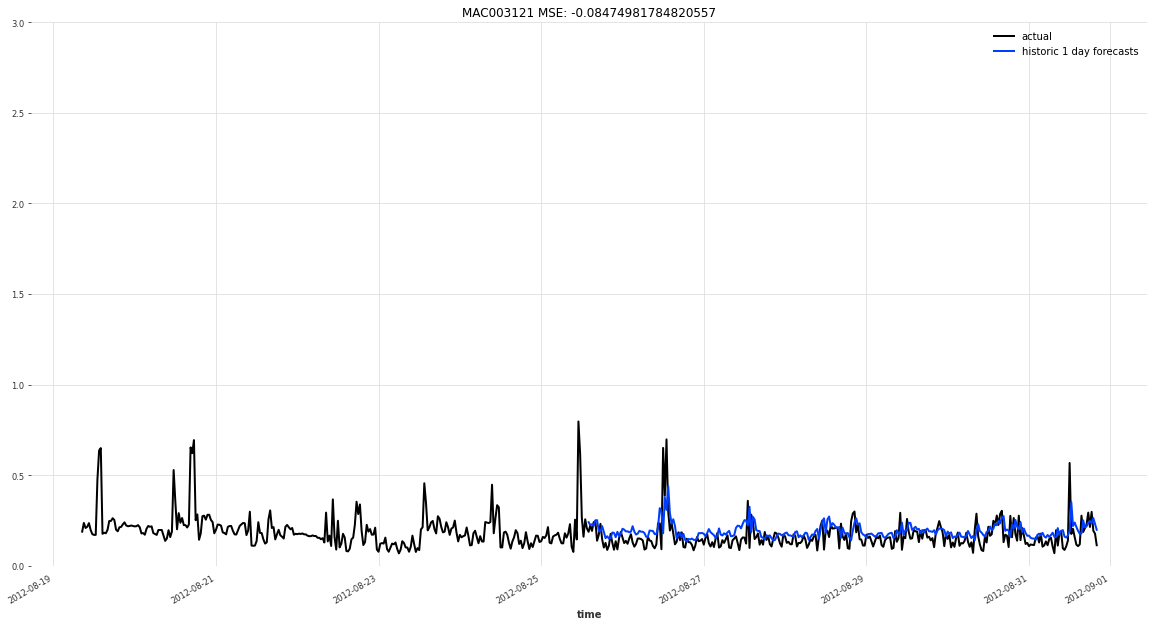

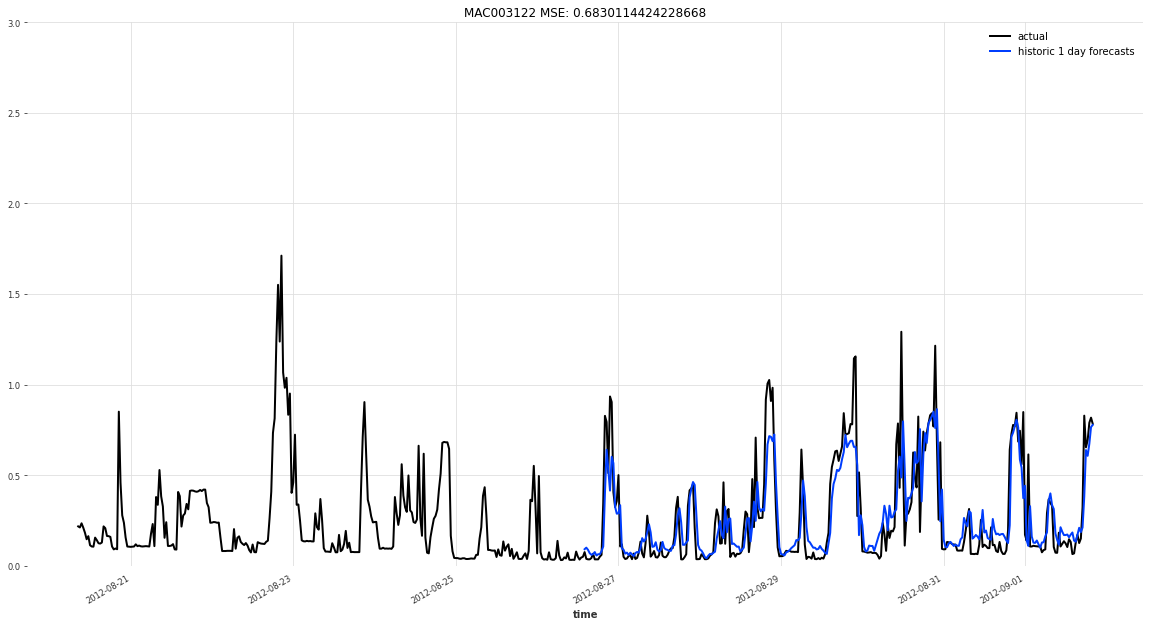

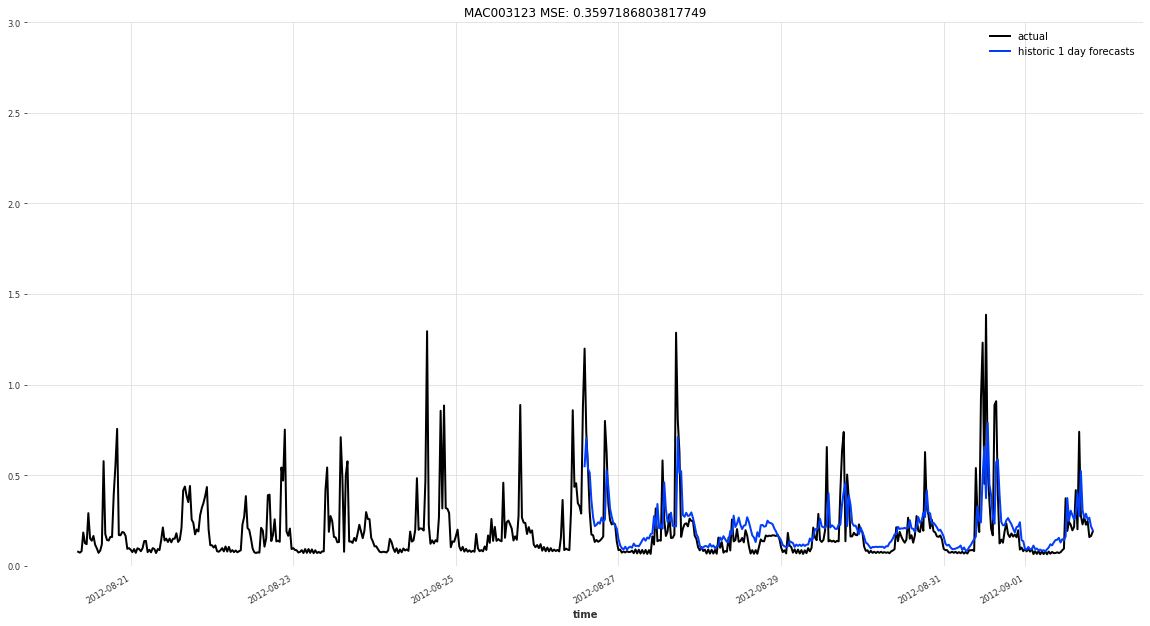

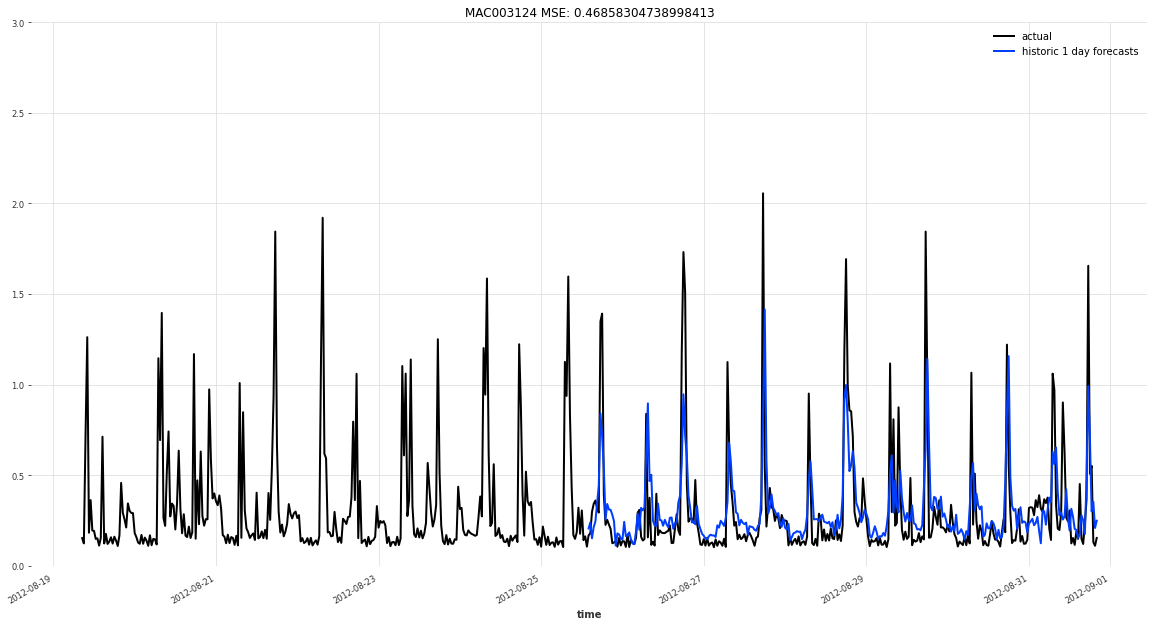

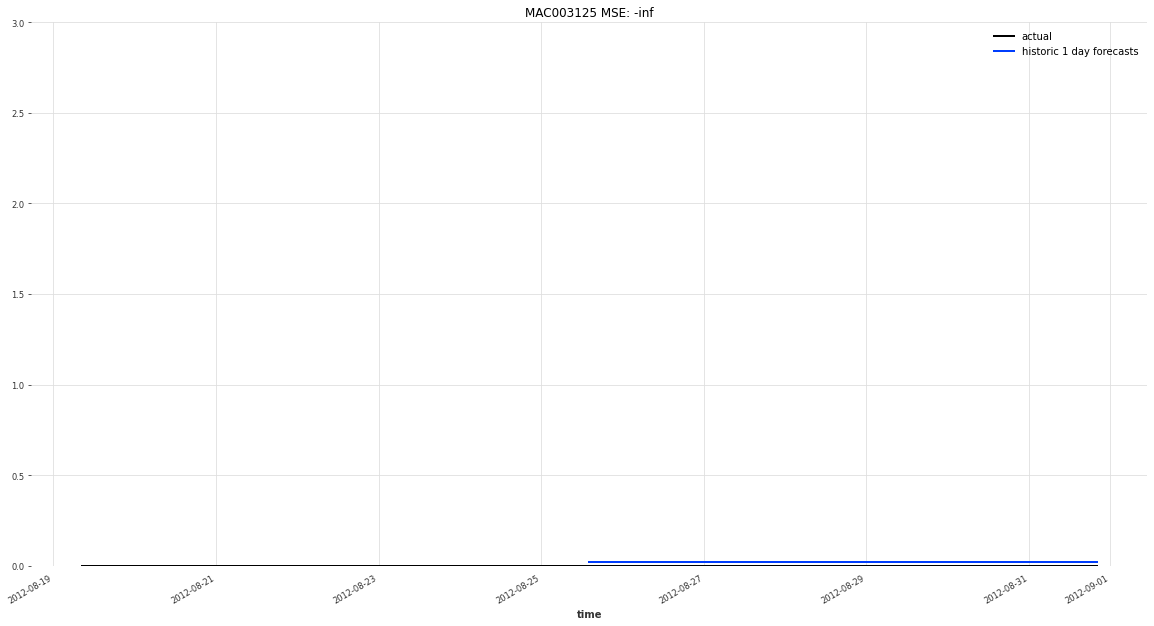

In [9]:
helper.eval(model, num_examples=5)

In [ ]:
helper.display_forecast(pred_series, series, "1 day", save=False, fig_name=f"test", model_name=f"{MODEL_NAME}", fig_size=(20,10))